### Logging imports and setup

In [1]:
LOGS_FOLDER = "logs"

import logging
from time import sleep, strftime, localtime, time

from pathlib import Path
Path(LOGS_FOLDER).mkdir(parents=True, exist_ok=True)

def timestamp():
    return strftime("%Y-%m-%d %H:%M:%S", localtime())

logging.basicConfig(
        filename=f'{LOGS_FOLDER}/log_{timestamp()}.txt',
        filemode='a',
        format='%(asctime)s - %(name)s - %(levelname)s - %(funcName)s() - %(message)s',
        level=logging.INFO
        )

def print_n_log(string):
    print(string)
    logging.info(string)


### Imports

In [2]:
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

from matplotlib import pyplot as plt

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

import torch
# torch.cuda.get_device_name(torch.cuda.current_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data

In [3]:
PATH_DATA = '../../../data'

noisy_imgs_1, noisy_imgs_2 = torch.load(PATH_DATA + '/train_data.pkl')

noisy_imgs, clean_imgs = torch.load(PATH_DATA + '/val_data.pkl')

In [4]:
noisy_imgs_1.shape, noisy_imgs_2.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000, 3, 32, 32]))

In [5]:
noisy_imgs.shape, clean_imgs.shape

(torch.Size([1000, 3, 32, 32]), torch.Size([1000, 3, 32, 32]))

In [6]:
train_input,train_target=noisy_imgs_1.float()/255.0,noisy_imgs_2.float()/255.0
test_input,test_target=noisy_imgs.float()/255.0,clean_imgs.float()/255.0

### Taking a small sample of data for fast training/expermientation. Comment if not needed

In [7]:
def subsample(tensor):
    n_samples = tensor.size(dim=0)
    return tensor[0:n_samples // 10]

train_input = subsample(train_input)
train_target = subsample(train_target)

train_input.shape, train_target.shape

(torch.Size([5000, 3, 32, 32]), torch.Size([5000, 3, 32, 32]))

### Basic data exploration

In [8]:
def show_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.show()


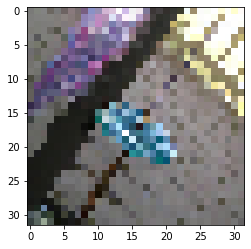

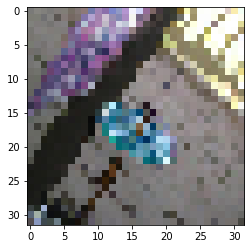

In [9]:
show_image(train_input[0])
show_image(train_target[0])

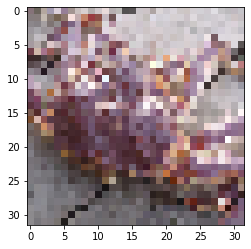

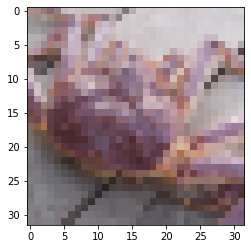

In [10]:
show_image(test_input[0])
show_image(test_target[0])

### Model, optimizer and loss function definitions

In [97]:
# michaelsmac, 1/10 training samples, 10 Epochs, 11s, psnr=23.74
model1 = nn.Sequential(
    nn.Linear(32, 128),
    nn.Linear(128, 32)
)

# michaelsmac, 1/10 training samples, 10 Epochs, 36s, psnr=24.75
model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.72
model2v1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.73
model2v2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 41s, psnr=23.56
model3 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1m, psnr=24.80
model4 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1.5m, psnr=24.73
model5 = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 13m, psnr=25.01
model6 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.Conv2d(32, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 5m, psnr=24.31
model_polling1 = nn.Sequential(
    # 1st layer
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Max pool 2x2
    nn.MaxPool2d(2, 2), # check ceil_mode=False

    #3nd layer
    nn.Conv2d(32, 128, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    #4th layer
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Up-conv 2x2
    nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, bias=False),

    #6th layer
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs
model_polling2 = nn.Sequential(
    # 1st layer
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # 2nd layer
    nn.Conv2d(32, 64, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Max pool 2x2
    nn.MaxPool2d(2, 2), # check ceil_mode=False

    #3nd layer
    nn.Conv2d(64, 128, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    #4th layer
    nn.ConvTranspose2d(128, 64, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Up-conv 2x2
    nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=False),

    #5th layer
    nn.ConvTranspose2d(64, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    #6th layer
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

In [98]:
model = model1; print_n_log(f'=== Using model1 ===')
# model = model2; print_n_log(f'=== Using model2 ===')
# model = model2v1; print_n_log(f'=== Using model2v1 ===')
# model = model2v2; print_n_log(f'=== Using model2v2 ===')
# model = model3; print_n_log(f'=== Using model3 ===')
# model = model4; print_n_log(f'=== Using model4 ===')
# model = model5; print_n_log(f'=== Using model5 ===')
# model = model_polling1; print_n_log(f'=== Using model_polling1 ===')

model.to(device)

=== Using model1 ===


Sequential(
  (0): Linear(in_features=32, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=32, bias=True)
)

In [99]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
# optimizer=torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn=nn.MSELoss().to(device)

In [100]:
def psnr(denoised,ground_truth):
    mse=torch.mean((denoised-ground_truth)**2)
    return  - 10 * torch.log10(((denoised-ground_truth) ** 2).mean((1,2,3))).mean()

### Model training and testing

In [101]:
batch_size = 20
nb_epochs = 10

for e in range(nb_epochs):
    print_n_log(f'Epoch -> {e}')
    losses=[]

    # Run optimization alg for all batches of data
    for b in range(0,train_input.size(0),batch_size):

        # Compute prediction error on batch
        pred = model(train_input.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_target.narrow(0, b, batch_size))
        losses.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_n_log(f'\tloss={sum(losses)/(train_input.size(0)/batch_size)}')

    # Print test psnr
    with torch.no_grad():
        print_n_log(f'\tpsnr={psnr(model(test_input), test_target)}')

Epoch -> 0
	loss=0.030094116926193237
	psnr=22.50701904296875
Epoch -> 1
	loss=0.016739582642912865
	psnr=23.484867095947266
Epoch -> 2
	loss=0.01607448421418667
	psnr=23.7044620513916
Epoch -> 3
	loss=0.015946319326758385
	psnr=23.753143310546875
Epoch -> 4
	loss=0.01592348888516426
	psnr=23.76236343383789
Epoch -> 5
	loss=0.015922438353300095
	psnr=23.75892448425293
Epoch -> 6
	loss=0.01592603139579296
	psnr=23.751497268676758
Epoch -> 7
	loss=0.015930308029055595
	psnr=23.747364044189453
Epoch -> 8
	loss=0.015934012830257416
	psnr=23.745922088623047
Epoch -> 9
	loss=0.015937140211462975
	psnr=23.74495506286621
